# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [4]:
def MLPR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline com MLPRegressor
    pipeline = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(20, 15, 10),  # Rede mais profunda para capturar detalhes da derivada
            activation='relu',                # ReLU para lidar com valores amplos
            solver='adam',
            alpha=0.2,                        # Regularização moderada
            max_iter=3000,
            random_state=42,
            learning_rate='adaptive',
            learning_rate_init=0.0003,        # Taxa de aprendizado inicial levemente aumentada
            batch_size=16
        )
    )


    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df

# Ajusta saída

In [5]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# SG - MLPR

=== Training Metrics ===
R²: 0.9515
Correlation coefficient: 0.9862
RMSE: 0.5430
MAE: 0.4069
Relative absolute error: 20.3498
Root relative squared error: 22.0186
Slope: 1.0536
Offset: -0.4062
=== Cross-Validation Metrics ===
R²: -1.5763
Correlation coefficient: 0.4593
RMSE: 3.9585
MAE: 3.0703
Relative absolute error: 153.5468
Root relative squared error: 160.5090
Slope: 0.2564
Offset: 10.5966
=== Validation Metrics ===
R²: -0.1595
Correlation coefficient: 0.6077
RMSE: 2.7437
MAE: 2.1280
Relative absolute error: 98.0830
Root relative squared error: 107.6824
Slope: 0.5856
Offset: 6.5137


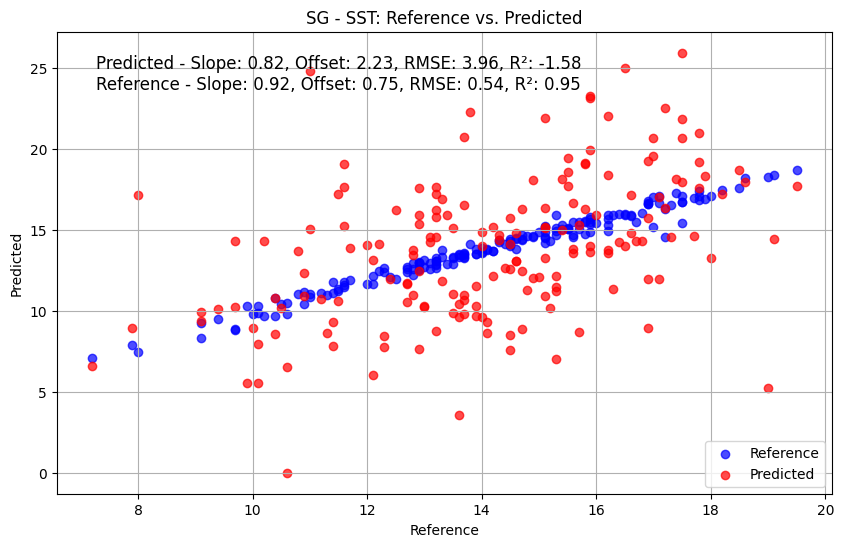

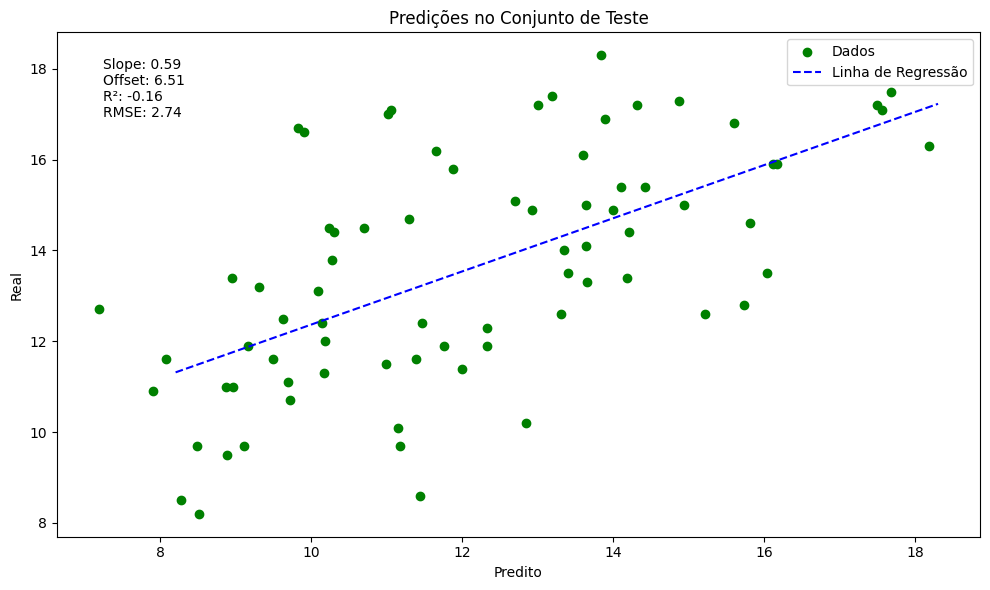

C:\Users\Luyza\AppData\Local\Temp\ipykernel_15464\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [6]:
results_sg_sst = MLPR(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'SST')

In [ ]:
results_sg_at = MLPR(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
infos_sg = add_plot_infos(infos_sg, results_sg_at, 'AT')

=== Training Metrics ===
R²: 0.9465
Correlation coefficient: 0.9742
RMSE: 0.1273
MAE: 0.0932
Relative absolute error: 23.3054
Root relative squared error: 23.1406
Slope: 0.9890
Offset: 0.0387


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


=== Training Metrics ===
R²: 0.9116
Correlation coefficient: 0.9777
RMSE: 0.0919
MAE: 0.0564
Relative absolute error: 23.4767
Root relative squared error: 29.7349
Slope: 1.2742
Offset: -0.8954
=== Cross-Validation Metrics ===
R²: 0.3720
Correlation coefficient: 0.6122
RMSE: 0.2448
MAE: 0.1493
Relative absolute error: 62.1613
Root relative squared error: 79.2488
Slope: 1.0954
Offset: -0.3138
=== Validation Metrics ===
R²: 0.5914
Correlation coefficient: 0.7696
RMSE: 0.1673
MAE: 0.1244
Relative absolute error: 53.0838
Root relative squared error: 63.9211
Slope: 0.9799
Offset: 0.0725


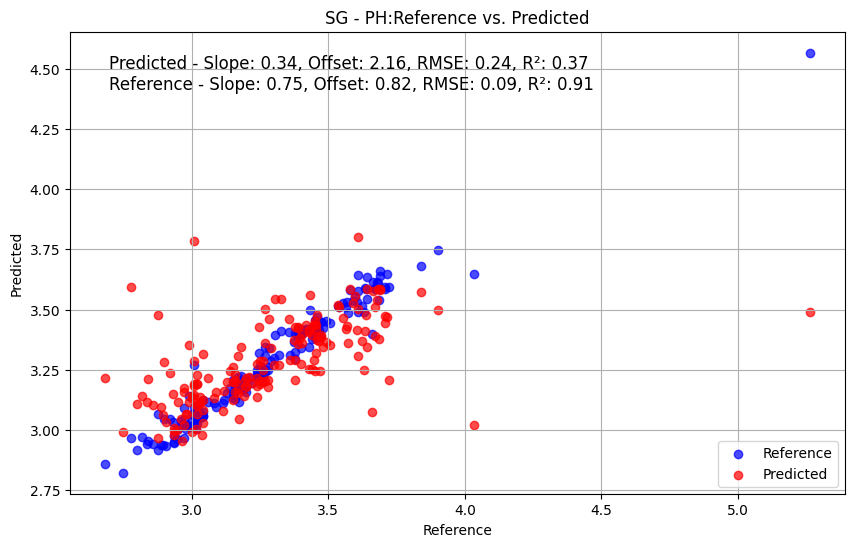

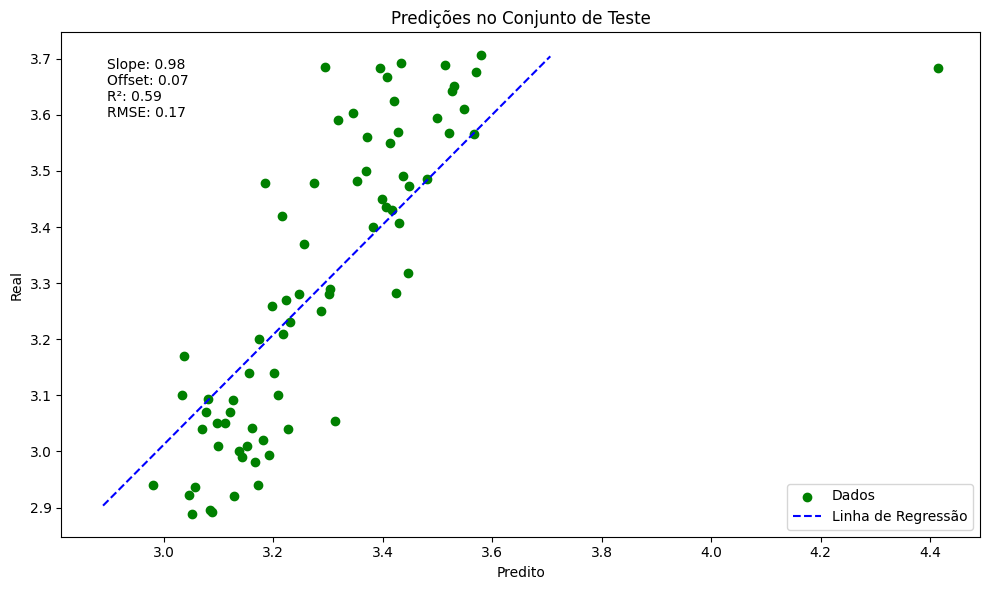

In [22]:
results_sg_ph = MLPR(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
infos_sg = add_plot_infos(infos_sg, results_sg_ph, 'PH')

=== Training Metrics ===
R²: 0.9221
Correlation coefficient: 0.9791
RMSE: 28.6864
MAE: 22.6840
Relative absolute error: 27.2409
Root relative squared error: 27.9127
Slope: 1.2422
Offset: -125.0583
=== Cross-Validation Metrics ===
R²: 0.4176
Correlation coefficient: 0.6492
RMSE: 78.4298
MAE: 62.5332
Relative absolute error: 75.0952
Root relative squared error: 76.3146
Slope: 1.1047
Offset: -54.7610
=== Validation Metrics ===
R²: 0.5301
Correlation coefficient: 0.7363
RMSE: 52.9539
MAE: 42.4037
Relative absolute error: 66.8147
Root relative squared error: 68.5475
Slope: 1.0464
Offset: -31.7348


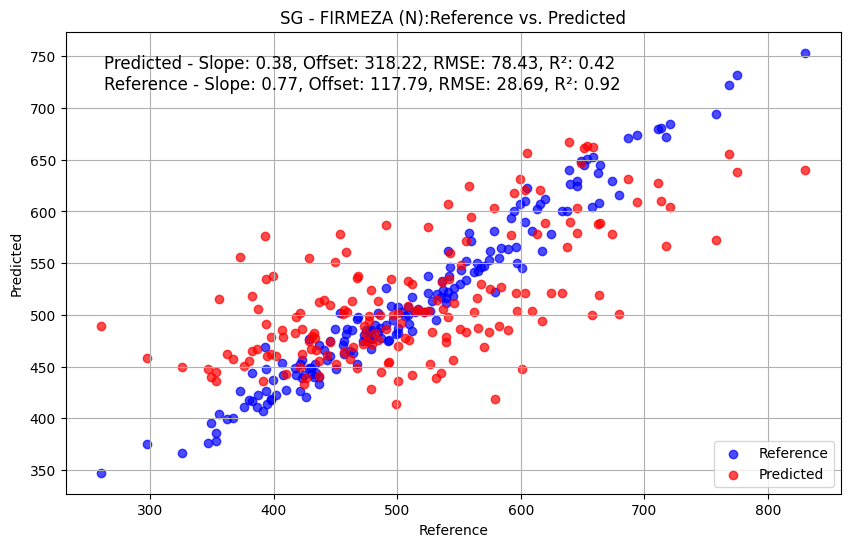

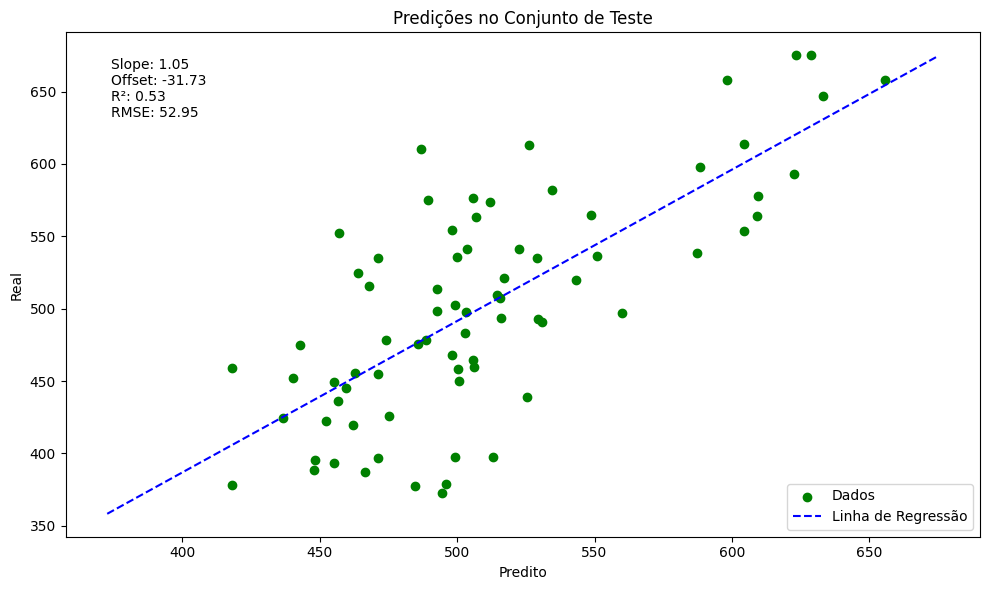

In [23]:
results_sg_firmeza = MLPR(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
infos_sg = add_plot_infos(infos_sg, results_sg_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9360
Correlation coefficient: 0.9751
RMSE: 0.8138
MAE: 0.4407
Relative absolute error: 17.8479
Root relative squared error: 25.3006
Slope: 1.1426
Offset: -2.1813
=== Cross-Validation Metrics ===
R²: 0.6324
Correlation coefficient: 0.8011
RMSE: 1.9502
MAE: 1.1409
Relative absolute error: 46.2047
Root relative squared error: 60.6329
Slope: 1.1383
Offset: -2.1304
=== Validation Metrics ===
R²: 0.7998
Correlation coefficient: 0.8962
RMSE: 0.9695
MAE: 0.7502
Relative absolute error: 42.2808
Root relative squared error: 44.7392
Slope: 0.9396
Offset: 0.9171


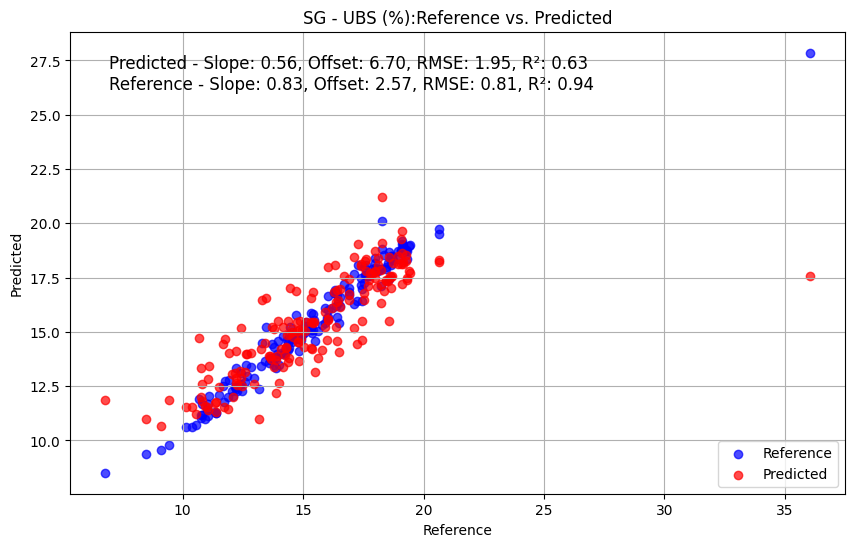

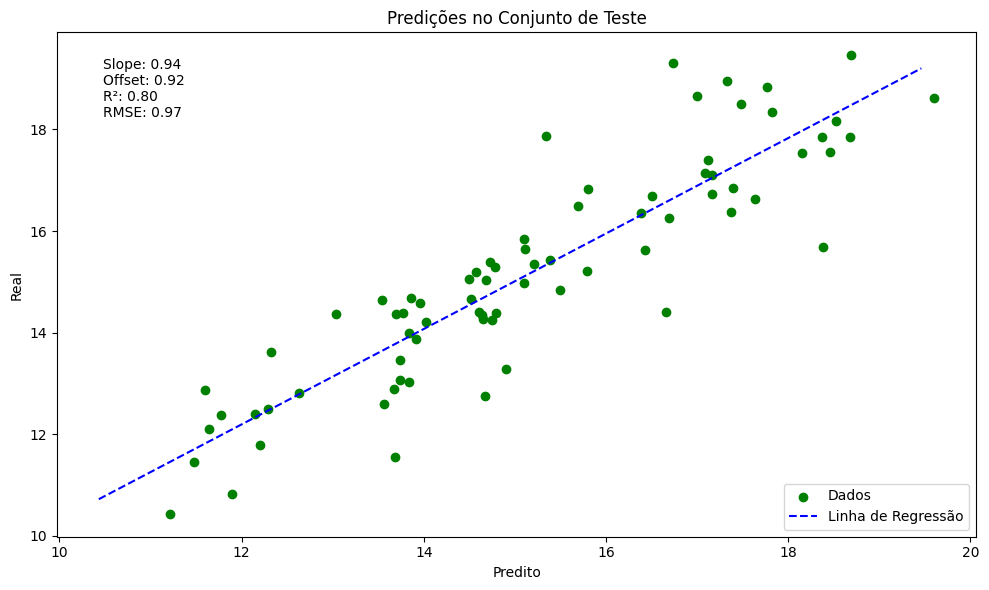

In [24]:
results_sg_ubs = MLPR(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
infos_sg = add_plot_infos(infos_sg, results_sg_ubs, 'UBS (%)')

In [25]:
infos_sg.to_excel('plot_infos_mlpr_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.963845,0.986705,0.505247,0.407400,18.422372,19.014459,1.111111,-1.549079
1,SST,Cross-Validation,0.730886,0.865281,1.378439,1.113829,50.366628,51.876165,1.182399,-2.563043
2,SST,Validation,0.742188,0.863001,1.067197,0.824550,48.028308,50.775162,1.017849,-0.145407
3,AT,Training,0.927184,0.976498,0.158295,0.092335,20.403338,26.984377,1.199319,-0.227229
4,AT,Cross-Validation,0.481355,0.695925,0.422465,0.250723,55.402315,72.017028,1.070827,-0.097639
5,AT,Validation,0.655756,0.823669,0.256334,0.196530,55.558840,58.672308,1.030355,-0.100303
6,PH,Training,0.911583,0.977730,0.091870,0.056404,23.476691,29.734930,1.274159,-0.895436
7,PH,Cross-Validation,0.371963,0.612218,0.244849,0.149346,62.161270,79.248758,1.095417,-0.313777
8,PH,Validation,0.591409,0.769585,0.167302,0.124428,53.083760,63.921147,0.979927,0.072512
9,FIRMEZA (N),Training,0.922088,0.979061,28.686377,22.683988,27.240863,27.912734,1.242155,-125.058331
